In [21]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
np.random.seed(0)

In [23]:
SAVE_FIGS = True
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "draft_plots")

In [22]:
r_shade_roi = np.linspace(0.01, 4, 100)
eta_shade_roi = np.linspace(-0.1, 0.1, 100)
beta_shade_roi = (eta_shade_roi + 1.5)/r_shade_roi
r_roi_mesh, eta_roi_mesh = np.meshgrid(r_shade_roi, eta_shade_roi)
beta_roi_mesh = (eta_roi_mesh + 1.5) / r_roi_mesh
roi_points = np.column_stack([r_roi_mesh.ravel(), (1 / beta_roi_mesh).ravel()])
roi_hull = ConvexHull(roi_points)

# SyntheticMRI2D

In [24]:
DATA_SET = "syntheticMRI2D"

In [25]:
kind = "layer"
all_hulls_df = pd.DataFrame(columns=["BAND", "hull", "CHANNEL", "DIRECTION"])
for DIRECTION in ["horizontal", "diagonal", "vertical"]:
    for view in ["coronal", "axial", "sagittal"]:
        DATA_NAME = f'{DATA_SET}-{view}' 
        TRANSFORM = f'wavelet-{DIRECTION}'
        CHANNEL = ""    
        path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
        
        if CHANNEL:
            path_list.append(CHANNEL)
        print(path_list)
        ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
        CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)


        DICT_PATH = os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle")
        MASTERDF_DIR = os.path.join(CWD, "CSVs", "master_df.csv")
        rEtaKsstats_dict = pd.read_pickle(DICT_PATH)
        master_df = pd.read_csv(MASTERDF_DIR)
        master_df = master_df.set_index("layer")
        master_df = master_df[master_df["total_samples"] > 9]
        hulls_df = region_reporting(rEtaKsstats_dict, master_df, layer = "all", MULT =1.2, kind = kind, plots=False, plot_name = "-".join(path_list))
        hulls_df["CHANNEL"] = view
        hulls_df["DIRECTION"] = DIRECTION
        all_hulls_df = pd.concat([all_hulls_df, hulls_df], ignore_index=True)
all_hulls_df = all_hulls_df.reset_index(drop=True)
all_hulls_df

['syntheticMRI2D', 'coronal', 'wavelet', 'horizontal']
['r_optimize', 'eta_optimize', 'ksstat_exclude_plus0']
0.025655270674456786 0.0097060218965063
Layer 3: None Passed
Rational Function Parameters: a=-0.5635940310279075, b=2.5995948271039397, c=-1.5685107495417294, d=-0.7856829299363572, e=8.678363477076937
Quadratic Function Parameters: a=-0.07337757333965801, b=0.35690343928091306, c=-0.22654005449557385
Linear Function Parameters: m=0.06358777737651107, c=0.046748180144641265
['r_optimize', 'eta_optimize', 'ksstat_exclude_plus0']
0.028813155809144828 0.0032201813174945
Layer 4: None Passed
Rational Function Parameters: a=-43.06916966153149, b=131.84692805723049, c=-61.97413647821454, d=-66.43653671689168, e=389.0901399354702
Quadratic Function Parameters: a=-0.13321095146115017, b=0.43060188774599356, c=-0.21246668345109757
Linear Function Parameters: m=0.055579268227822554, c=0.0365247411761207
['r_optimize', 'eta_optimize', 'ksstat_exclude_plus0']
0.00351448756129904 0.00149898

,BAND,hull,CHANNEL,DIRECTION
0,3,"[[3.5004140913537936, 0.16228346321252368], [3...",coronal,horizontal
1,4,"[[1.499415906453205, 0.20033510562019602], [0....",coronal,horizontal
2,5,"[[1.4004361870953417, 1.054203041998678], [0.1...",coronal,horizontal
3,6,"[[20.001392166800102, 33.33615910383389], [8.3...",coronal,horizontal
4,7,"[[1.0006056706550095, 1.6662147798389249], [1....",coronal,horizontal
...,...,...,...,...
58,5,"[[1.4989392713991103, 1.4998092533141225], [1....",sagittal,vertical
59,6,"[[0.499794445770906, 0.6265347025472594], [0.0...",sagittal,vertical
60,7,"[[0.5014436861338392, 0.7129168412152262], [0....",sagittal,vertical
61,8,"[[0.3990893276056279, 0.49809153079543894], [0...",sagittal,vertical


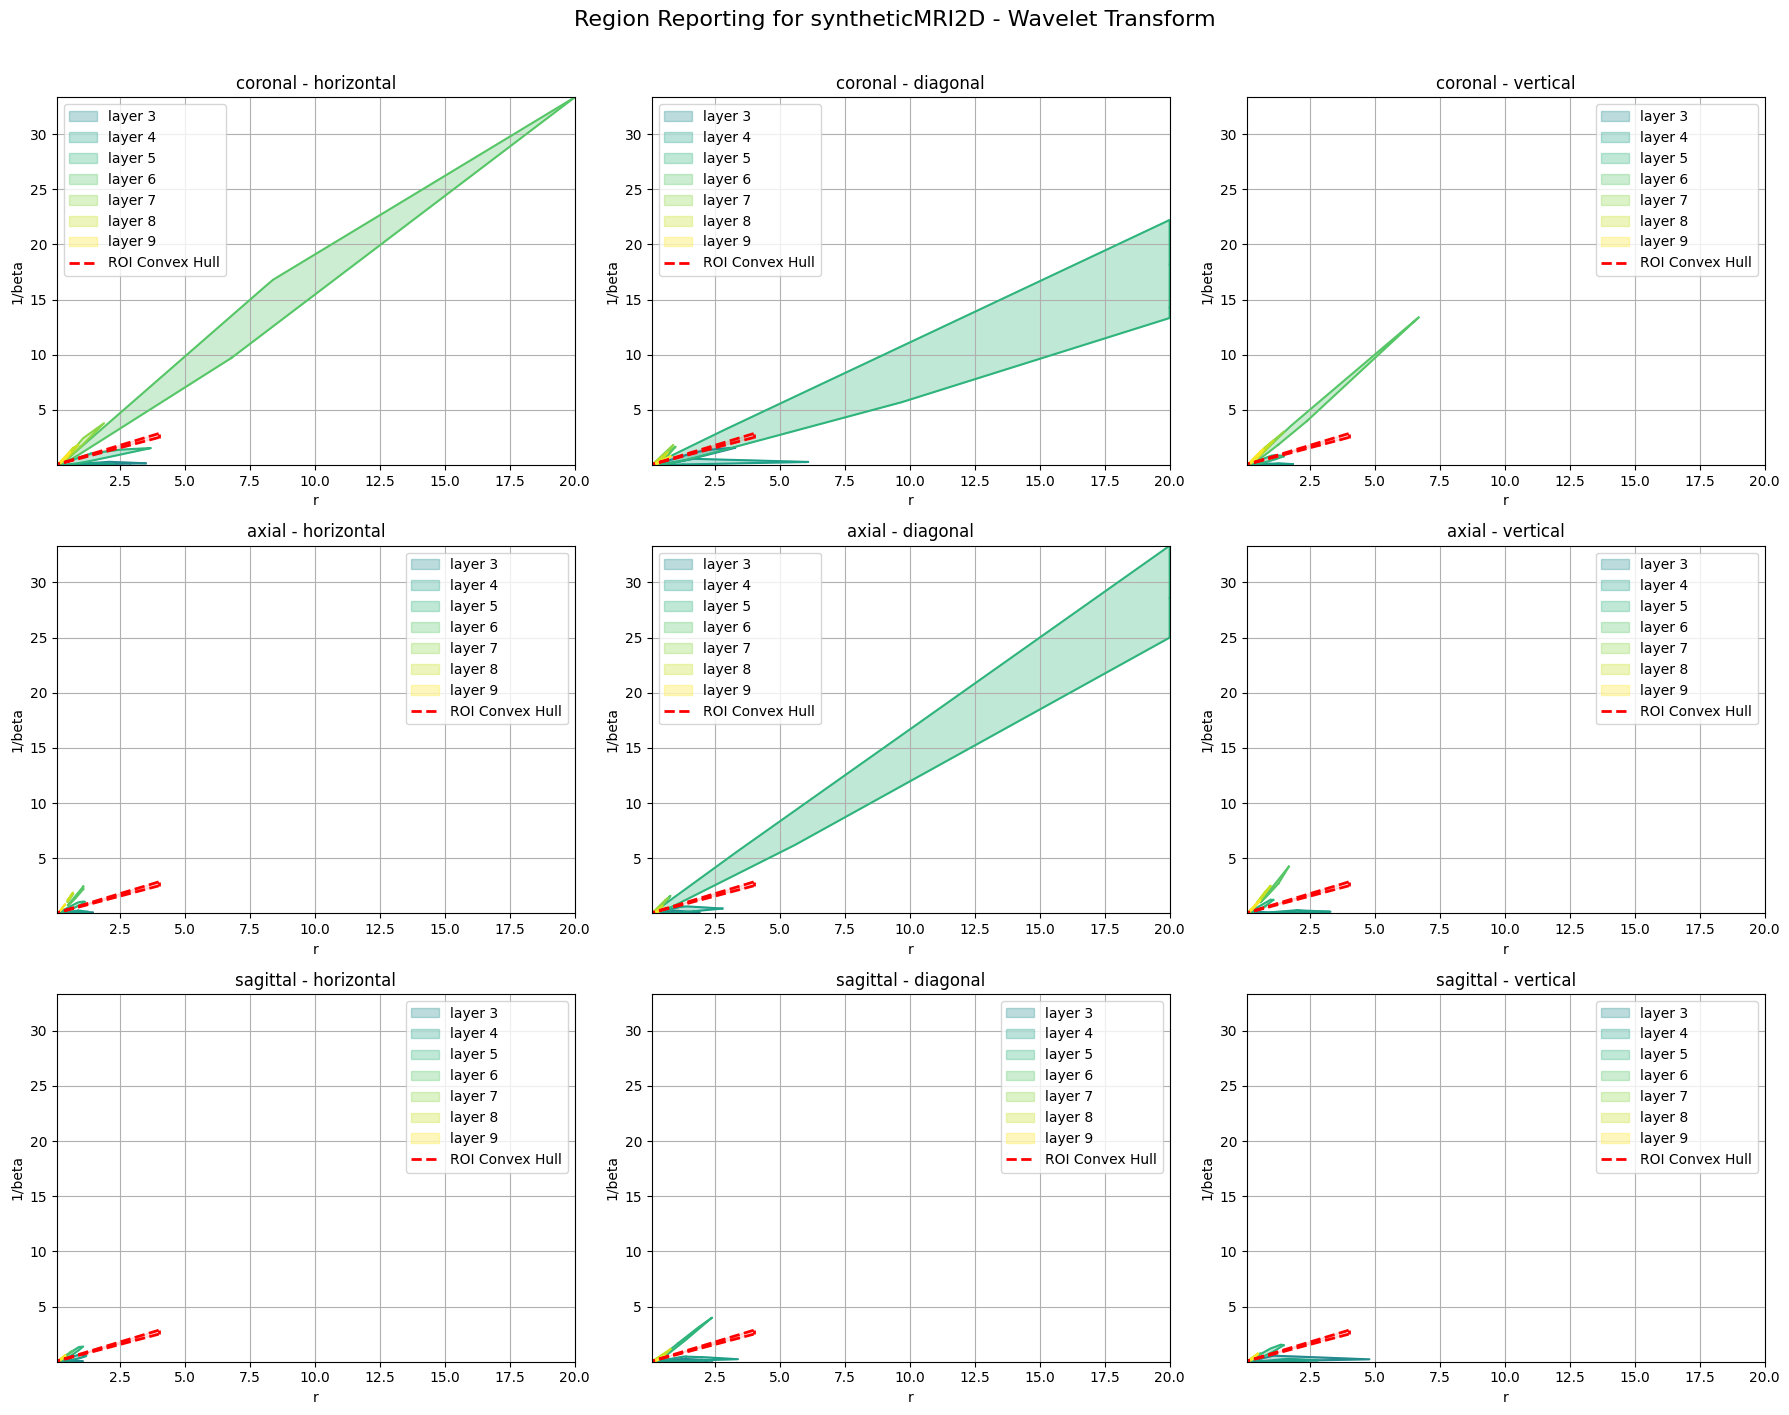

In [26]:
# Find global min/max for all hulls
all_points = np.concatenate([np.array(hull).reshape(-1, 2) for hull in all_hulls_df['hull']])
x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()

channels = all_hulls_df["CHANNEL"].unique()
directions = all_hulls_df["DIRECTION"].unique()

fig, axes = plt.subplots(len(channels), len(directions), figsize=(6 * len(directions), 5 * len(channels)), squeeze=False)

for i, channel in enumerate(channels):
    for j, direction in enumerate(directions):
        ax = axes[i, j]
        subset = all_hulls_df[(all_hulls_df["CHANNEL"] == channel) & (all_hulls_df["DIRECTION"] == direction)]
        if subset.empty:
            ax.set_title(f"{channel} - {direction}\n(No Data)")
            ax.axis('off')
            continue
        max_band = subset["BAND"].astype(int).max()
        colors = plt.cm.viridis(np.linspace(0.3, 1, max_band))
        for _, row in subset.iterrows():
            BAND = int(row['BAND'])
            hull = np.array(row['hull'])
            color = colors[BAND - 1]
            ax.fill(hull[:, 0], hull[:, 1], color=color, alpha=0.3, label=f'{kind} {BAND}')
            ax.plot(hull[:, 0], hull[:, 1], color=color)
            ax.plot([hull[-1, 0], hull[0, 0]], [hull[-1, 1], hull[0, 1]], color=color)

        #ADD ROI
        ax.plot(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], 'r--', lw=2, label='ROI Convex Hull')
        ax.fill(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], color='red', alpha=0.1)
        ax.plot([roi_points[roi_hull.vertices[-1], 0], roi_points[roi_hull.vertices[0], 0]],
                 [roi_points[roi_hull.vertices[-1], 1], roi_points[roi_hull.vertices[0], 1]],'r--', lw=2)
        
        ax.set_title(f"{channel} - {direction}")
        ax.set_xlabel('r')
        ax.set_ylabel('1/beta')
        ax.legend()
        ax.grid()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

plt.suptitle(f"Region Reporting for {DATA_SET} - Wavelet Transform", fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, f"Region Reporting for {DATA_SET} - Wavelet Transform.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')

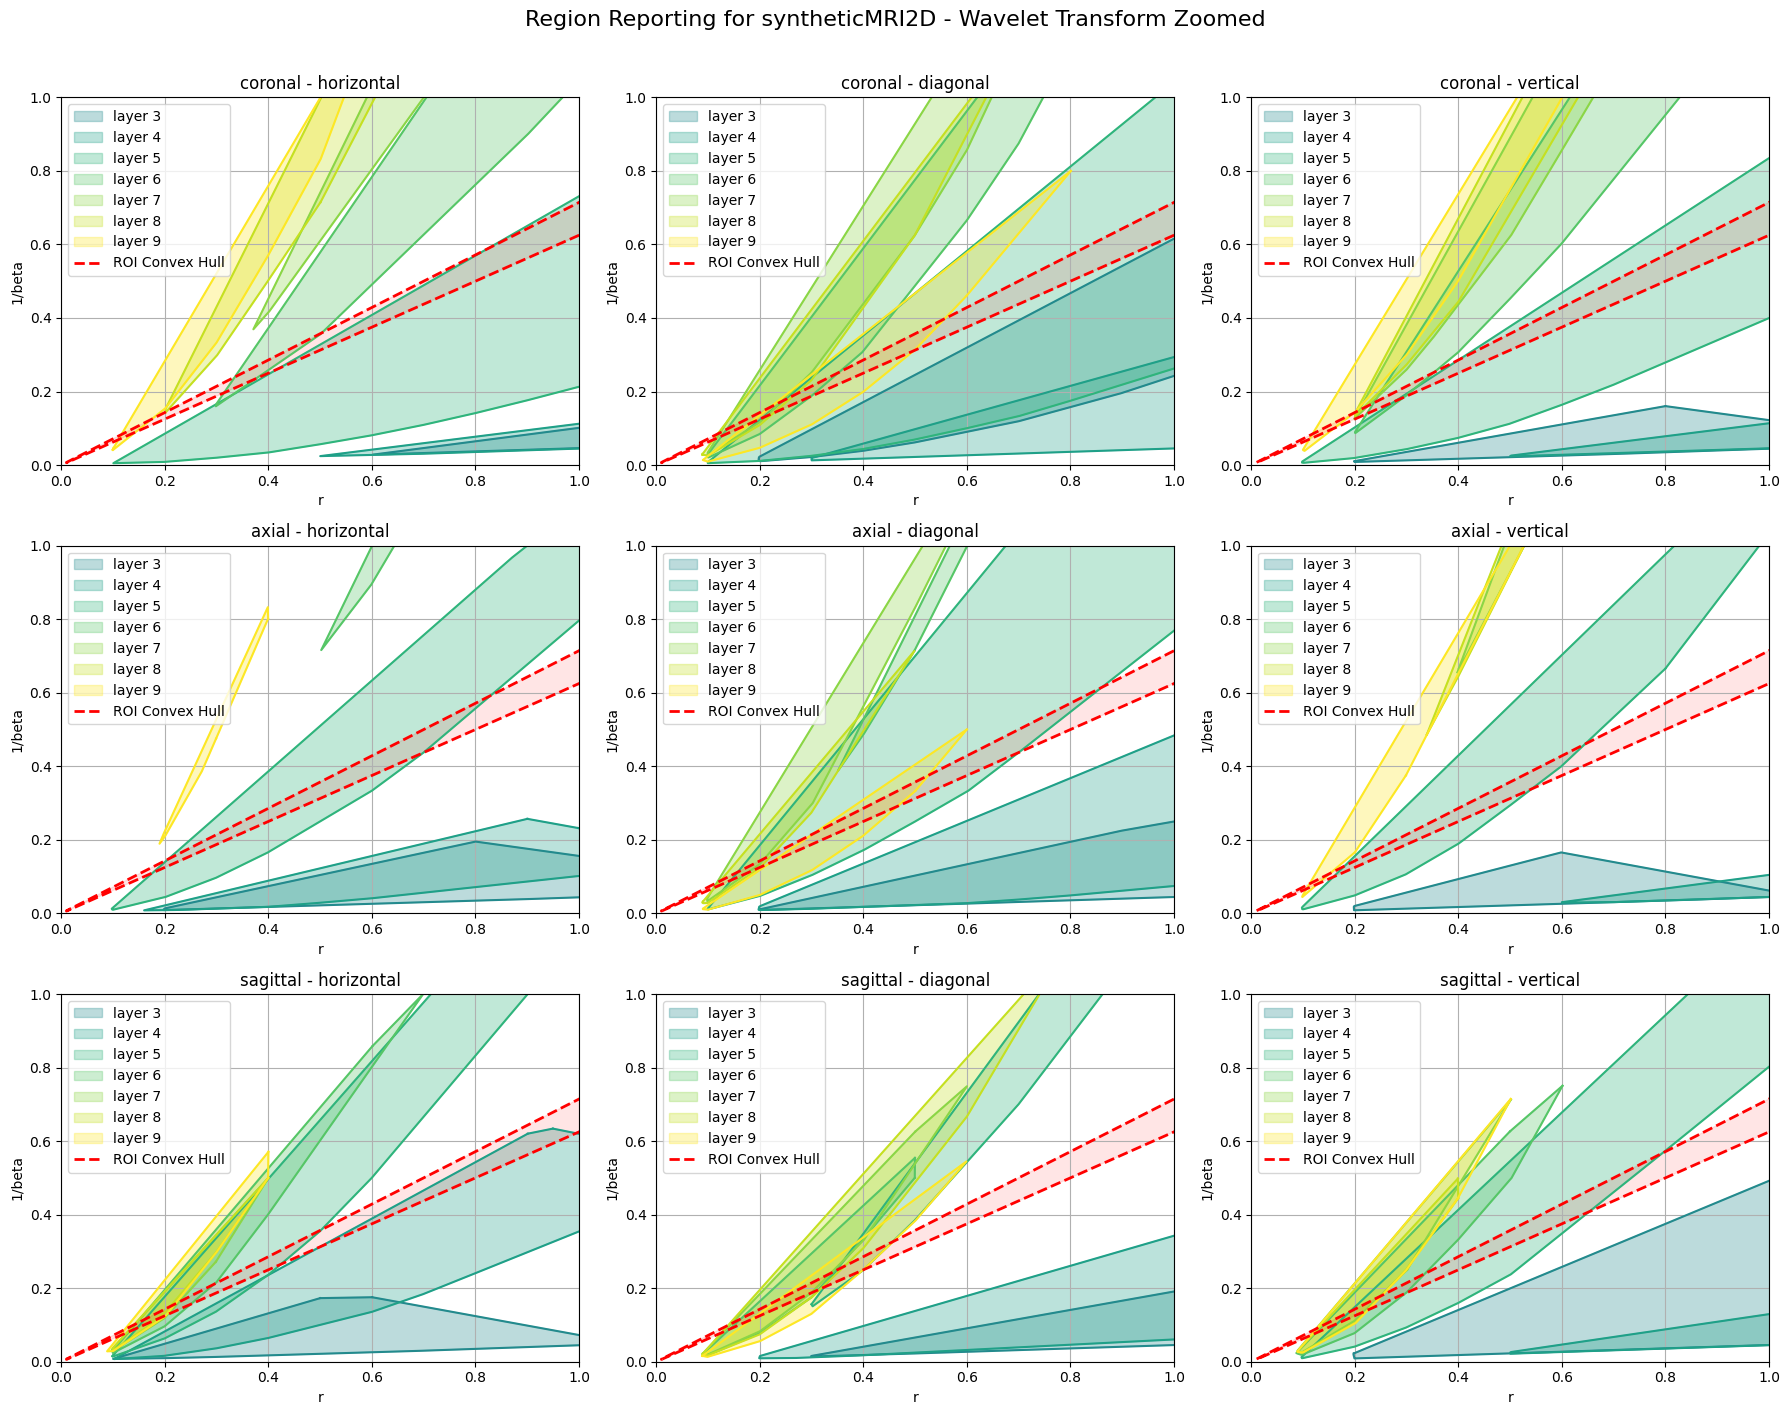

In [27]:
# Find global min/max for all hulls
all_points = np.concatenate([np.array(hull).reshape(-1, 2) for hull in all_hulls_df['hull']])
x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()

channels = all_hulls_df["CHANNEL"].unique()
directions = all_hulls_df["DIRECTION"].unique()

fig, axes = plt.subplots(len(channels), len(directions), figsize=(6 * len(directions), 5 * len(channels)), squeeze=False)

for i, channel in enumerate(channels):
    for j, direction in enumerate(directions):
        ax = axes[i, j]
        subset = all_hulls_df[(all_hulls_df["CHANNEL"] == channel) & (all_hulls_df["DIRECTION"] == direction)]
        if subset.empty:
            ax.set_title(f"{channel} - {direction}\n(No Data)")
            ax.axis('off')
            continue
        max_band = subset["BAND"].astype(int).max()
        colors = plt.cm.viridis(np.linspace(0.3, 1, max_band))
        for _, row in subset.iterrows():
            BAND = int(row['BAND'])
            hull = np.array(row['hull'])
            color = colors[BAND - 1]
            ax.fill(hull[:, 0], hull[:, 1], color=color, alpha=0.3, label=f'{kind} {BAND}')
            ax.plot(hull[:, 0], hull[:, 1], color=color)
            ax.plot([hull[-1, 0], hull[0, 0]], [hull[-1, 1], hull[0, 1]], color=color)

        #ADD ROI
        ax.plot(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], 'r--', lw=2, label='ROI Convex Hull')
        ax.fill(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], color='red', alpha=0.1)
        ax.plot([roi_points[roi_hull.vertices[-1], 0], roi_points[roi_hull.vertices[0], 0]],
                 [roi_points[roi_hull.vertices[-1], 1], roi_points[roi_hull.vertices[0], 1]],'r--', lw=2)
        
        
        ax.set_title(f"{channel} - {direction}")
        ax.set_xlabel('r')
        ax.set_ylabel('1/beta')
        ax.legend()
        ax.grid()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

plt.suptitle(f"Region Reporting for {DATA_SET} - Wavelet Transform Zoomed", fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, f"Region Reporting for {DATA_SET} - Wavelet Transform Zoomed.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')


# SyntheticMRI3D

In [28]:
DATA_SET = "syntheticMRI3D"

In [29]:
kind = "layer"
all_hulls_df = pd.DataFrame(columns=["BAND", "hull", "CHANNEL", "DIRECTION"])
for DIRECTION in ["aad", "ada", "add","daa", "dad", "dda", "ddd"]:
    DATA_NAME = f'{DATA_SET}-full' 
    TRANSFORM = f'wavelet-{DIRECTION}'
    CHANNEL = ""    
    path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
    
    if CHANNEL:
        path_list.append(CHANNEL)
    print(path_list)
    ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
    CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)


    DICT_PATH = os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle")
    MASTERDF_DIR = os.path.join(CWD, "CSVs", "master_df.csv")
    rEtaKsstats_dict = pd.read_pickle(DICT_PATH)
    master_df = pd.read_csv(MASTERDF_DIR)
    master_df = master_df.set_index("layer")
    master_df = master_df[master_df["total_samples"] > 9]
    hulls_df = region_reporting(rEtaKsstats_dict, master_df, layer = "all", MULT =1.2, kind = kind, plots=False, plot_name = "-".join(path_list))
    hulls_df["CHANNEL"] = ""
    hulls_df["DIRECTION"] = DIRECTION
    all_hulls_df = pd.concat([all_hulls_df, hulls_df], ignore_index=True)
all_hulls_df = all_hulls_df.reset_index(drop=True)
all_hulls_df

['syntheticMRI3D', 'full', 'wavelet', 'aad']
['r_optimize', 'eta_optimize', 'ksstat_exclude_plus0']
0.18286514673349297 0.0568820832907503
Layer 3: None Passed
Rational Function Parameters: a=-1.0840868636426915, b=1.062733946864576, c=-0.12818770335044508, d=-2.022820372179831, e=3.3841812952617363
Quadratic Function Parameters: a=-0.3998735525039789, b=0.4231040501148163, c=-0.05646140293804937
Linear Function Parameters: m=0.0690555199384407, c=0.013933897933838181
['r_optimize', 'eta_optimize', 'ksstat_exclude_plus0']
0.013331376572995523 0.0090389255084191
Layer 4: None Passed
Rational Function Parameters: a=-0.8678795244685239, b=1.2449339536576427, c=-0.2342399366887577, d=-11.712584496347295, e=14.531015494659586
Quadratic Function Parameters: a=-0.06223276703885819, b=0.15981390634953416, c=-0.04763502733704334
Linear Function Parameters: m=0.05254991456211506, c=-0.002675081515235058
['r_optimize', 'eta_optimize', 'ksstat_exclude_plus0']
0.0054190549567658675 0.00249240695741

,BAND,hull,CHANNEL,DIRECTION
0,3,"[[0.7902484990613505, 0.03546894323897742], [0...",,aad
1,4,"[[1.1190407052086826, 0.05271206306230242], [1...",,aad
2,5,"[[0.9002449345769655, 0.4293171631959541], [0....",,aad
3,6,"[[0.8998712257543096, 1.1238413363551771], [0....",,aad
4,7,"[[0.09841154324335134, 0.02885757699181833], [...",,aad
5,8,"[[0.09751458467013197, 0.02952819565638478], [...",,aad
6,3,"[[1.0715416058337364, 0.049076636250121174], [...",,ada
7,4,"[[0.568753044841359, 0.33503638701081434], [0....",,ada
8,5,"[[0.08898696187234727, 0.014631062960001924], ...",,ada
9,6,"[[1.1987684234305833, 2.0019131008481446], [0....",,ada


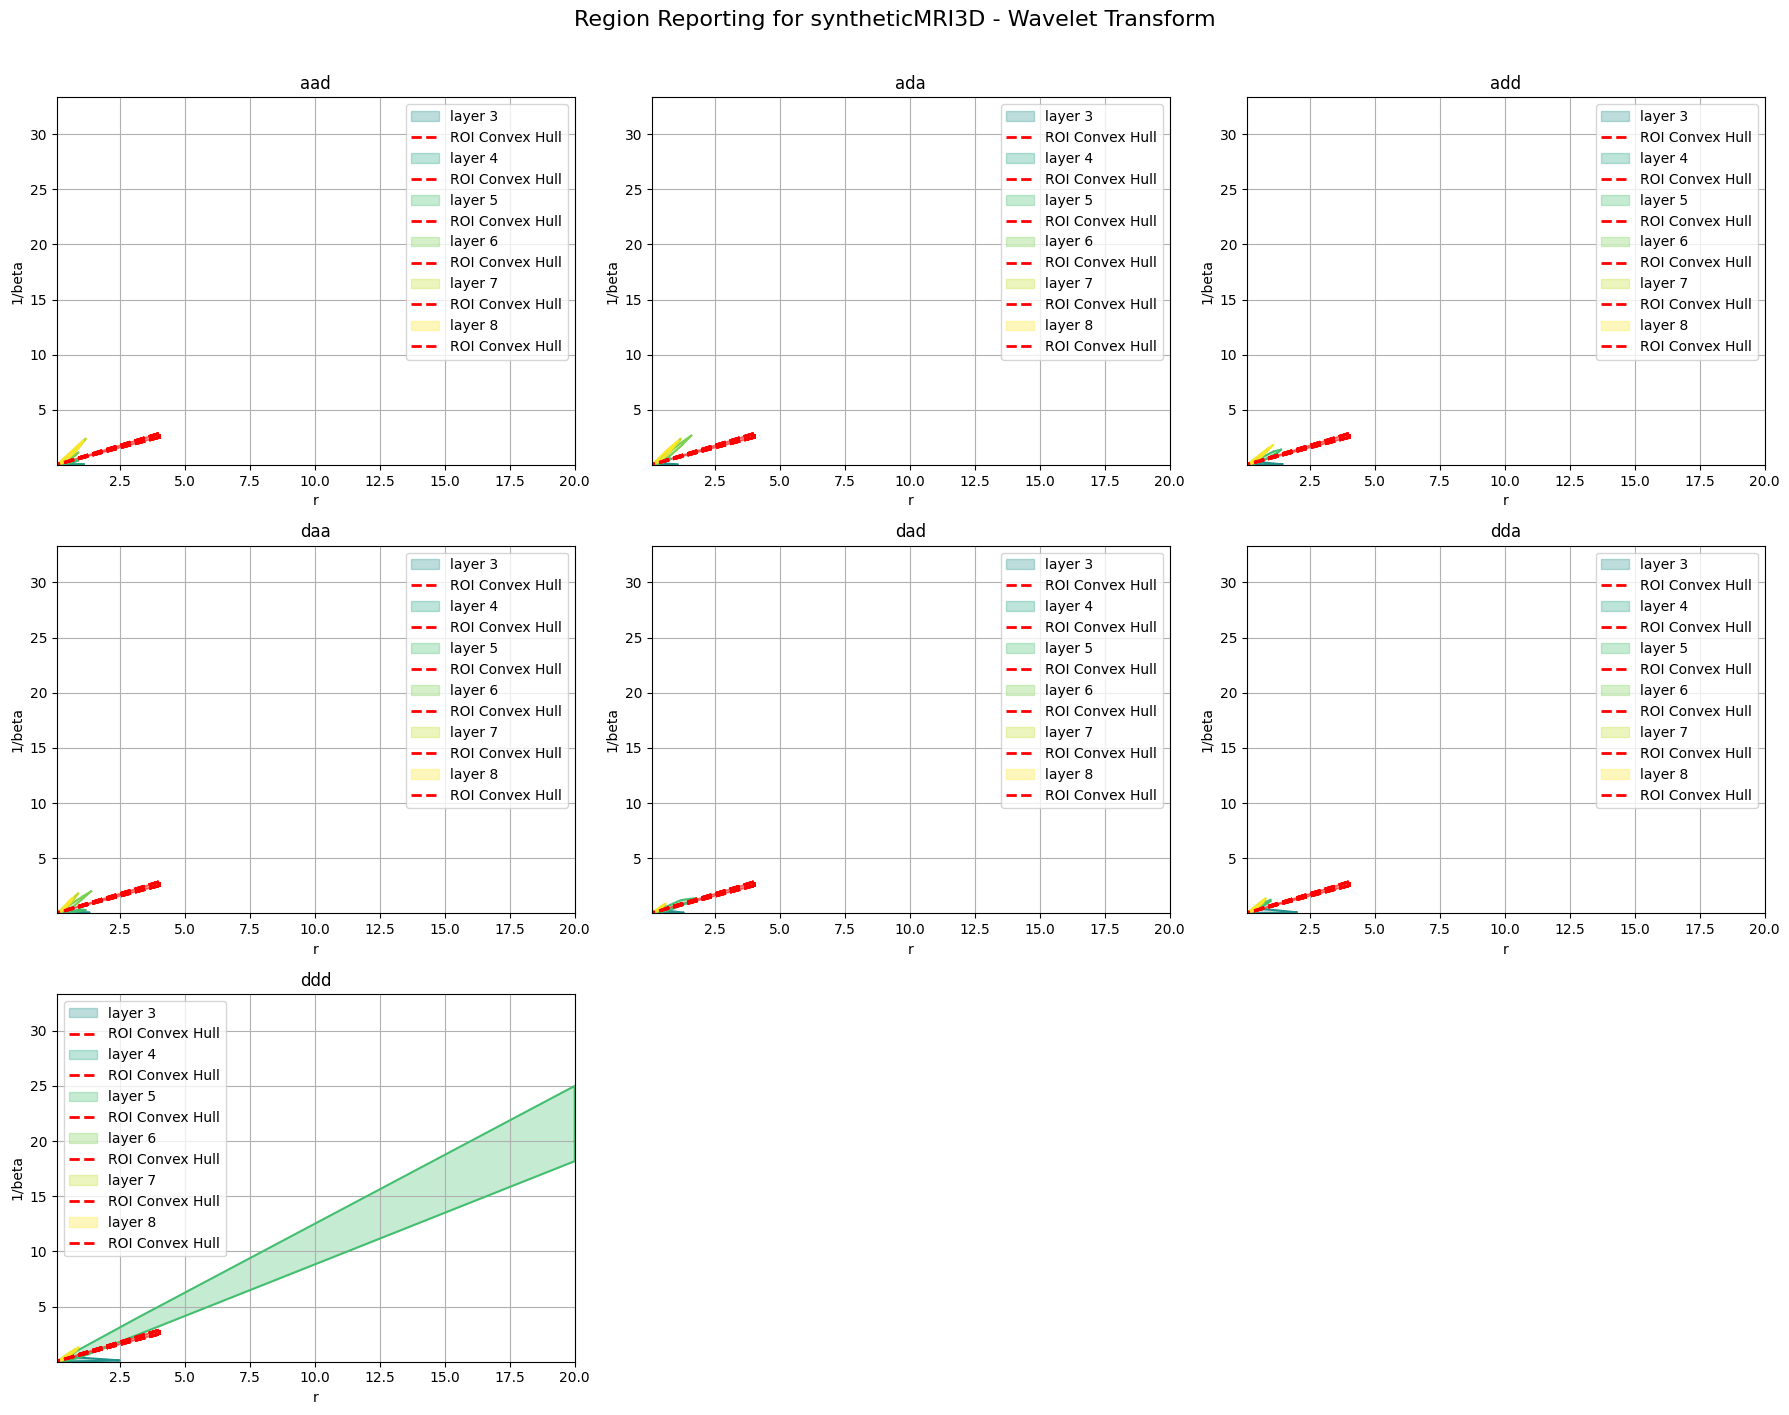

In [ ]:


directions = all_hulls_df["DIRECTION"].unique()
n_directions = len(directions)
n_rows = 3
n_cols = math.ceil(n_directions / n_rows)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False)

for idx, direction in enumerate(directions):
    i, j = divmod(idx, n_cols)
    ax = axes[i, j]
    subset = all_hulls_df[all_hulls_df["DIRECTION"] == direction]
    if subset.empty:
        ax.set_title(f"{direction}\n(No Data)")
        ax.axis('off')
        continue
    max_band = subset["BAND"].astype(int).max()
    colors = plt.cm.viridis(np.linspace(0.3, 1, max_band))
    for _, row in subset.iterrows():
        BAND = int(row['BAND'])
        hull = np.array(row['hull'])
        color = colors[BAND - 1]
        ax.fill(hull[:, 0], hull[:, 1], color=color, alpha=0.3, label=f'{kind} {BAND}')
        ax.plot(hull[:, 0], hull[:, 1], color=color)
        ax.plot([hull[-1, 0], hull[0, 0]], [hull[-1, 1], hull[0, 1]], color=color)

    #ADD ROI
        ax.plot(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], 'r--', lw=2, label='ROI Convex Hull')
        ax.fill(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], color='red', alpha=0.1)
        ax.plot([roi_points[roi_hull.vertices[-1], 0], roi_points[roi_hull.vertices[0], 0]],
                 [roi_points[roi_hull.vertices[-1], 1], roi_points[roi_hull.vertices[0], 1]],'r--', lw=2)
        
    ax.set_title(f"{direction}")
    ax.set_xlabel('r')
    ax.set_ylabel('1/beta')
    ax.legend()
    ax.grid()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

# Hide any unused subplots
for idx in range(n_directions, n_rows * n_cols):
    i, j = divmod(idx, n_cols)
    axes[i, j].axis('off')

plt.suptitle(f"Region Reporting for {DATA_SET} - Wavelet Transform", fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, f"Region Reporting for {DATA_SET} - Wavelet Transform.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')

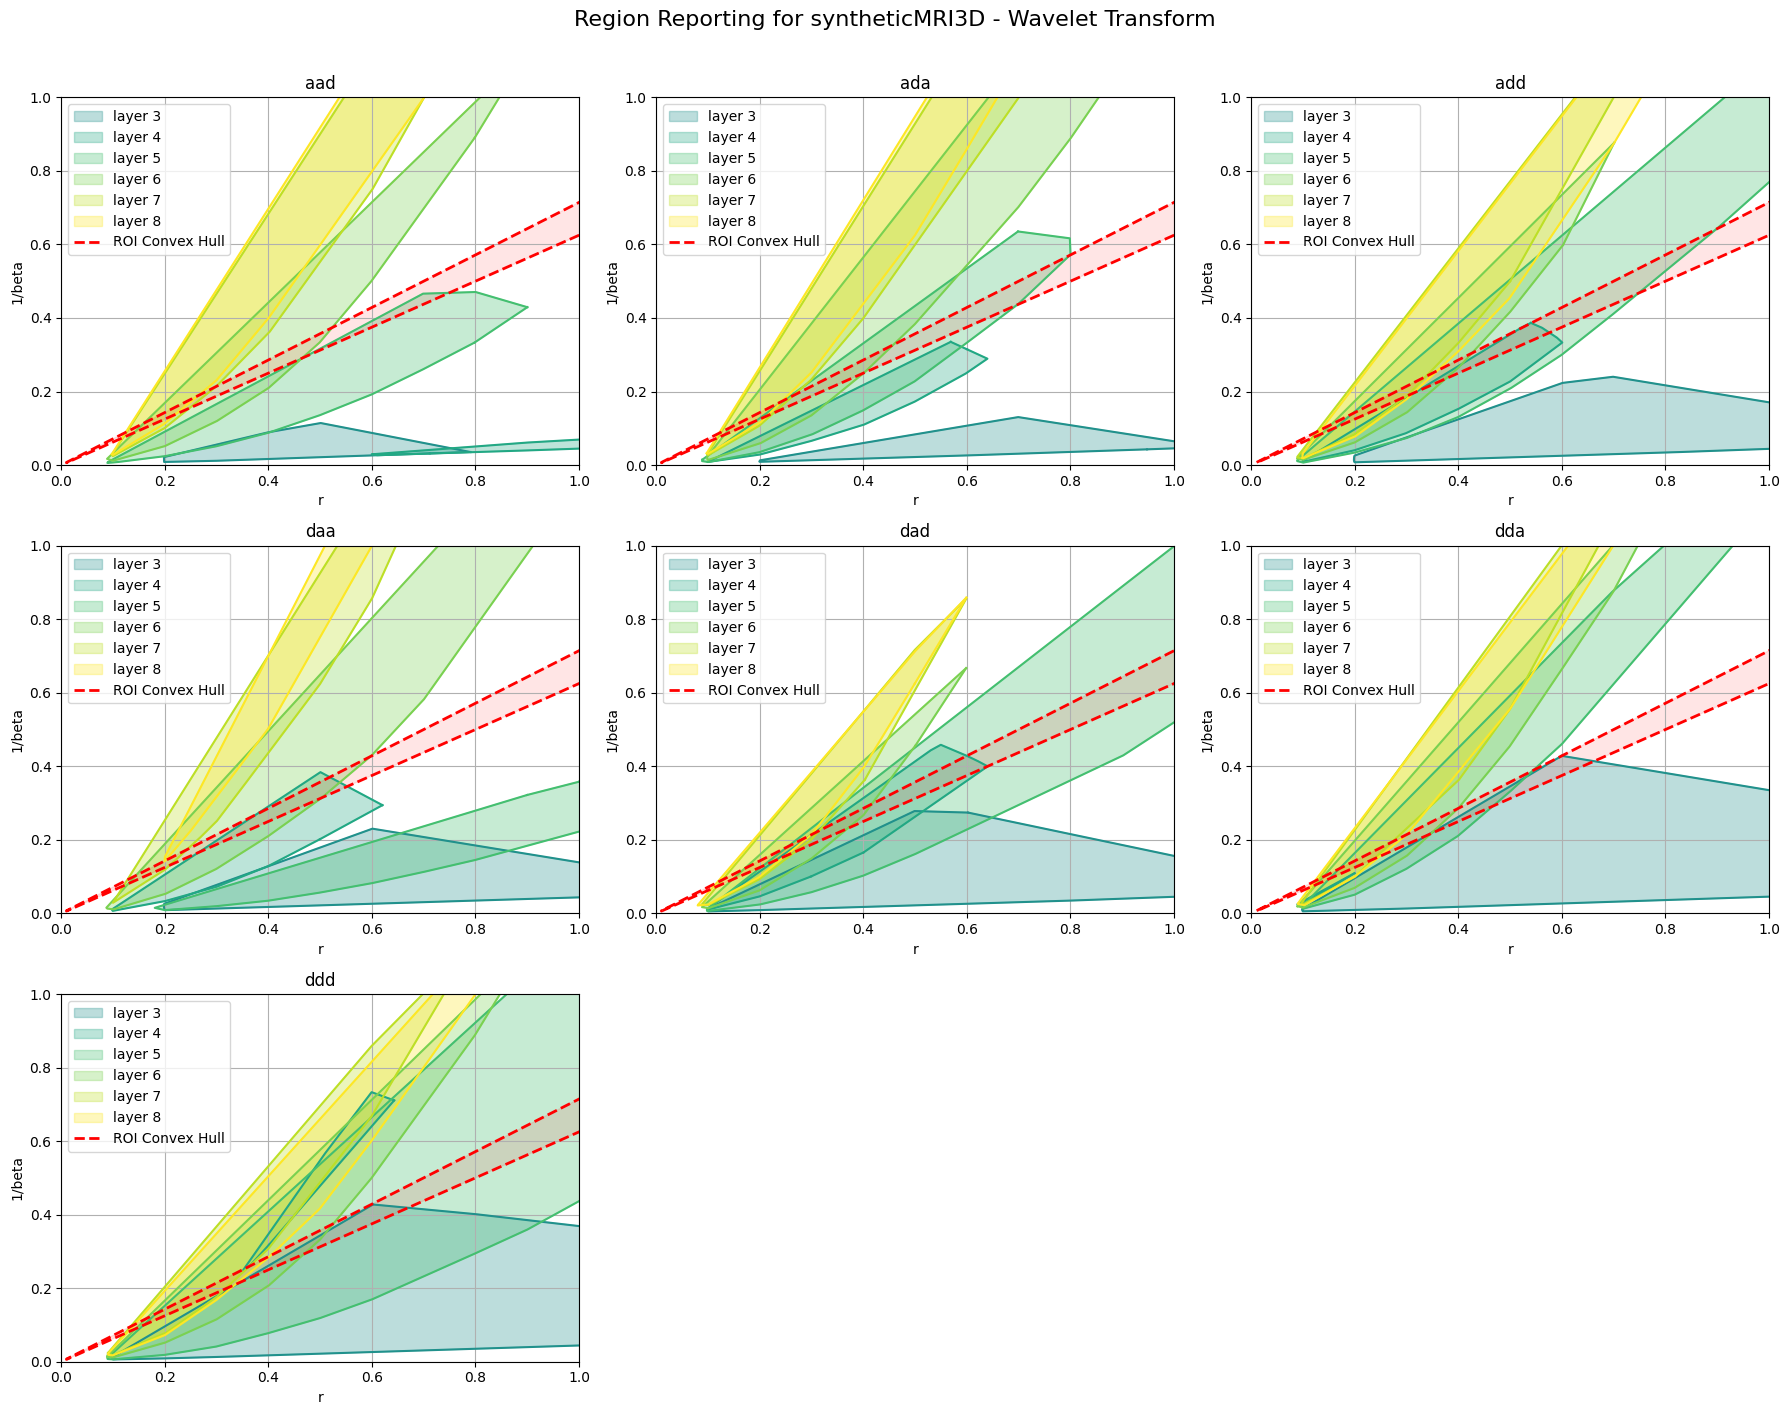

In [31]:
import math

directions = all_hulls_df["DIRECTION"].unique()
n_directions = len(directions)
n_rows = 3
n_cols = math.ceil(n_directions / n_rows)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False)

for idx, direction in enumerate(directions):
    i, j = divmod(idx, n_cols)
    ax = axes[i, j]
    subset = all_hulls_df[all_hulls_df["DIRECTION"] == direction]
    if subset.empty:
        ax.set_title(f"{direction}\n(No Data)")
        ax.axis('off')
        continue
    max_band = subset["BAND"].astype(int).max()
    colors = plt.cm.viridis(np.linspace(0.3, 1, max_band))
    for _, row in subset.iterrows():
        BAND = int(row['BAND'])
        hull = np.array(row['hull'])
        color = colors[BAND - 1]
        ax.fill(hull[:, 0], hull[:, 1], color=color, alpha=0.3, label=f'{kind} {BAND}')
        ax.plot(hull[:, 0], hull[:, 1], color=color)
        ax.plot([hull[-1, 0], hull[0, 0]], [hull[-1, 1], hull[0, 1]], color=color)

    #ADD ROI
    ax.plot(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], 'r--', lw=2, label='ROI Convex Hull')
    ax.fill(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], color='red', alpha=0.1)
    ax.plot([roi_points[roi_hull.vertices[-1], 0], roi_points[roi_hull.vertices[0], 0]],
                [roi_points[roi_hull.vertices[-1], 1], roi_points[roi_hull.vertices[0], 1]],'r--', lw=2)

    ax.set_title(f"{direction}")
    ax.set_xlabel('r')
    ax.set_ylabel('1/beta')
    ax.legend()
    ax.grid()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

# Hide any unused subplots
for idx in range(n_directions, n_rows * n_cols):
    i, j = divmod(idx, n_cols)
    axes[i, j].axis('off')

plt.suptitle(f"Region Reporting for {DATA_SET} - Wavelet Transform", fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, f"Region Reporting for {DATA_SET} - Wavelet Transform Zoomed.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')
